# 配置环境

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("Setup Complete")

Setup Complete


# 差分隐私处理

## Step 1 import packages

In [4]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

## Step 2 user-defined parameteres

In [5]:
# input dataset
file_name = "diabetes_subset"
input_data = "./data/" + file_name + ".csv"
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f"./out/{mode}/" + file_name + "_synthetic_description.json"
synthetic_data = f"./out/{mode}/" + file_name + "_synthetic_data.csv"

input_data, description_file, synthetic_data

('./data/diabetes_subset.csv',
 './out/correlated_attribute_mode/diabetes_subset_synthetic_description.json',
 './out/correlated_attribute_mode/diabetes_subset_synthetic_data.csv')

In [6]:
input_df = pd.read_csv(input_data)
input_df.head()

,Pregnancies,BMI,Age,Insulin,BloodPressure,Outcome
0,6,33.6,50,0,72,1
1,1,26.6,31,0,66,0
2,8,23.3,32,0,64,1
3,1,28.1,21,94,66,0
4,0,43.1,33,168,40,1


In [7]:
input_df.shape

(768, 6)

In [8]:
# An attribute is categorical if its domain size is less than this threshold.
# Here modify the threshold to adapt to the domain size of "education" (which is 14 in input dataset).
threshold_value = 10

# specify categorical attributes
# categorical_attributes = {'education': True}
categorical_attributes = {}

# specify which attributes are candidate keys of input dataset.
# candidate_keys = {'ssn': True}
candidate_keys = {}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 100

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = input_df.shape[0] # Here input_df.shape[0] is the same as input dataset, but it can be set to another number.

## Step 3 DataDescriber

1. Instantiate a DataDescriber.
2. Compute the statistics of the dataset.
3. Save dataset description to a file on local machine.

In [9]:
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT Insulin
Adding attribute Age
Adding attribute Pregnancies
Adding attribute BloodPressure
Adding attribute BMI
Adding attribute Outcome
========================== BN constructed ==========================


In [10]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    Age           has parents ['Insulin'].
    Pregnancies   has parents ['Age', 'Insulin'].
    BloodPressure has parents ['Pregnancies', 'Age'].
    BMI           has parents ['Pregnancies', 'Age'].
    Outcome       has parents ['Pregnancies', 'Age'].


## Step 4 generate synthetic dataset

1. Instantiate a DataGenerator.
2. Generate a synthetic dataset.
3. Save it to local machine.

In [11]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

## Step 5 compare the statistics of input and sythetic data (optional)

The synthetic data is already saved in a file by step 4. The ModelInspector is for a quick test on the similarity between input and synthetic datasets.

### 5.1 instantiate a ModelInspector.

It needs input dataset, synthetic dataset, and attribute description.

In [12]:
input_df.head()

,Pregnancies,BMI,Age,Insulin,BloodPressure,Outcome
0,6,33.6,50,0,72,1
1,1,26.6,31,0,66,0
2,8,23.3,32,0,64,1
3,1,28.1,21,94,66,0
4,0,43.1,33,168,40,1


In [13]:
synthetic_df = pd.read_csv(synthetic_data)
synthetic_df.head()

,Pregnancies,BMI,Age,Insulin,BloodPressure,Outcome
0,15.0,38.383346,42.0,126.0,74.0,1
1,1.0,23.743816,38.0,177.0,65.0,1
2,1.0,24.917369,22.0,164.0,70.0,0
3,7.0,59.567448,64.0,85.0,100.0,1
4,2.0,22.912430,21.0,65.0,80.0,0


In [14]:
synthetic_df.columns

Index(['Pregnancies', 'BMI', 'Age', 'Insulin', 'BloodPressure', 'Outcome'], dtype='object')

In [15]:
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)

### 5.2 compare histograms between input and synthetic datasets.

Pregnancies
BMI
Age
Insulin
BloodPressure
Outcome


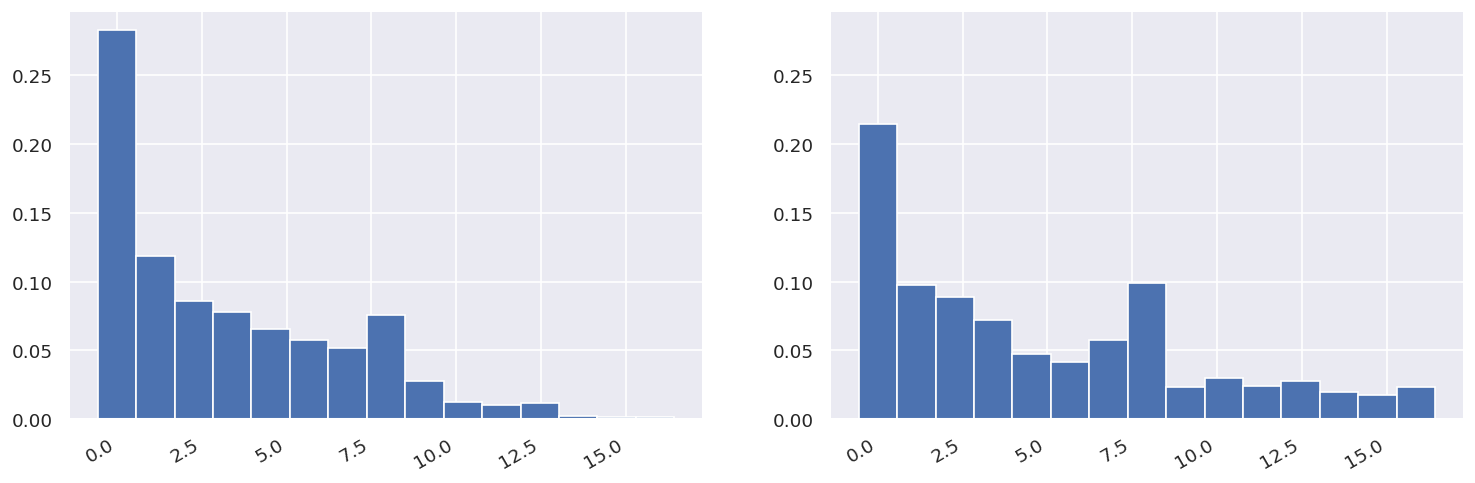

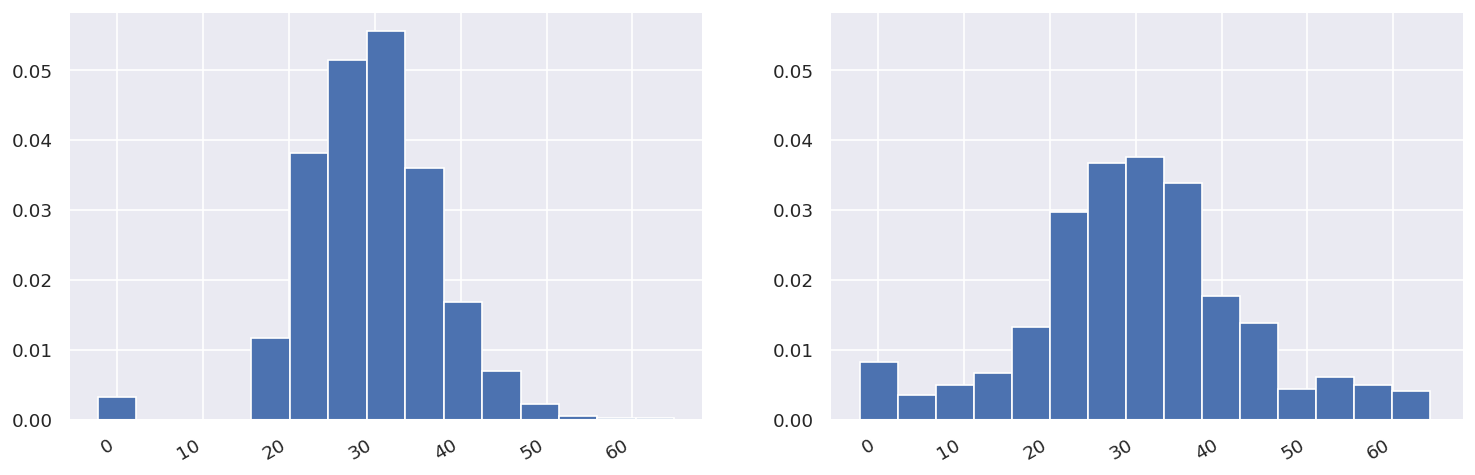

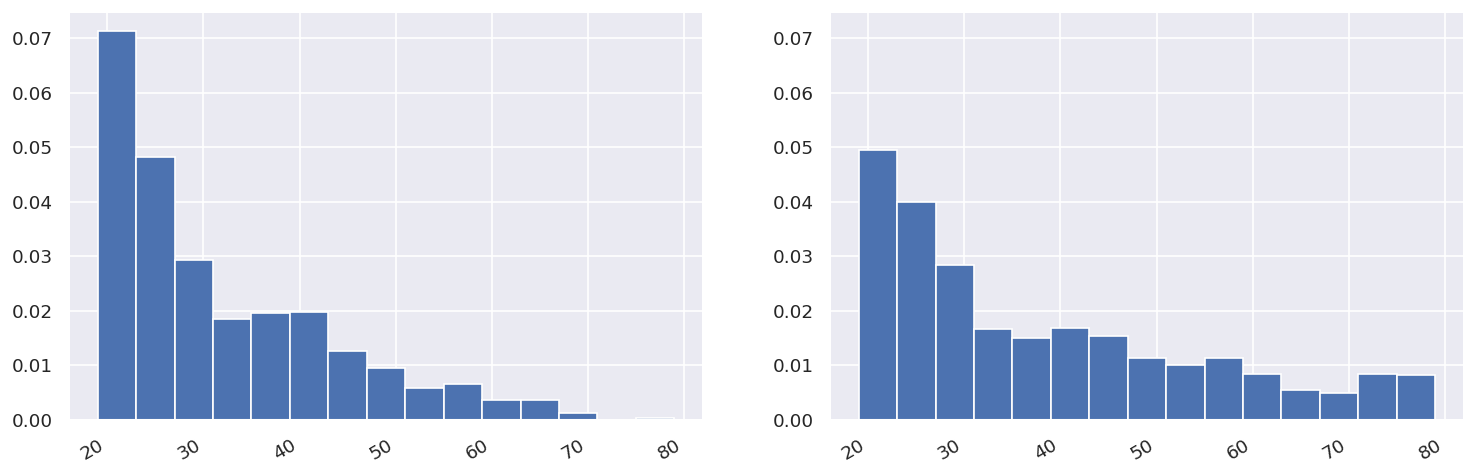

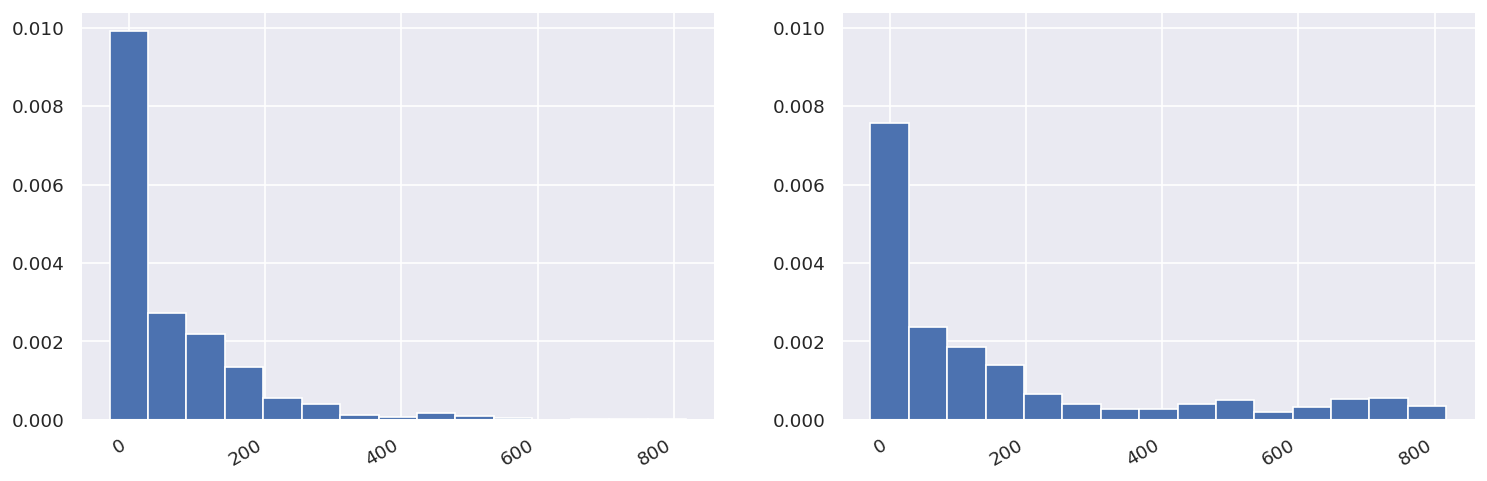

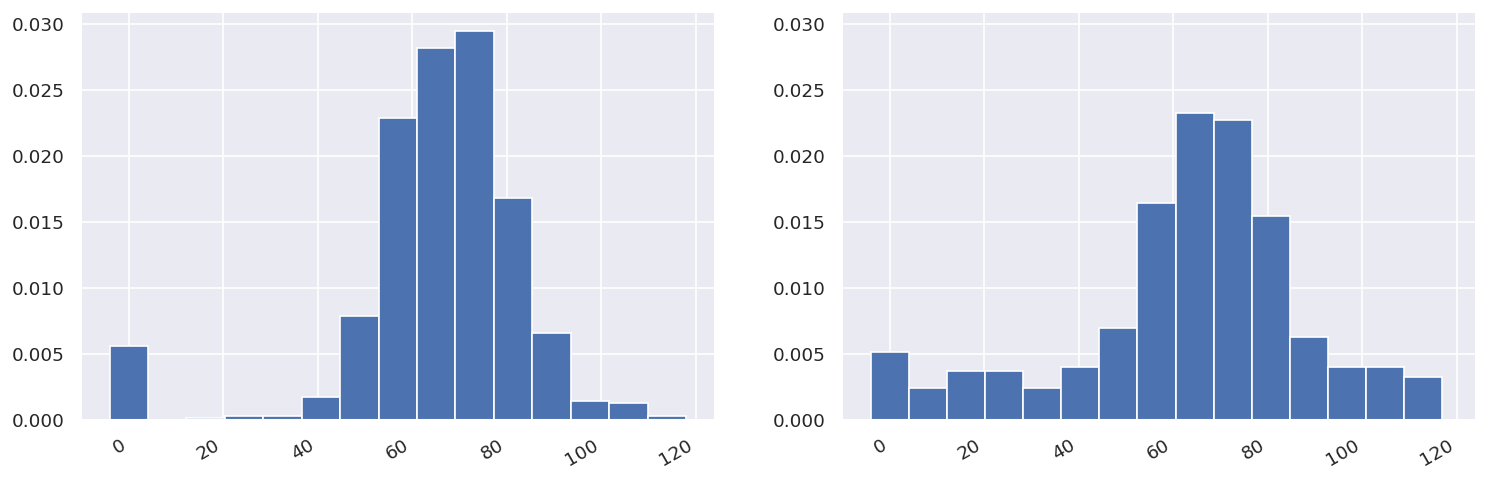

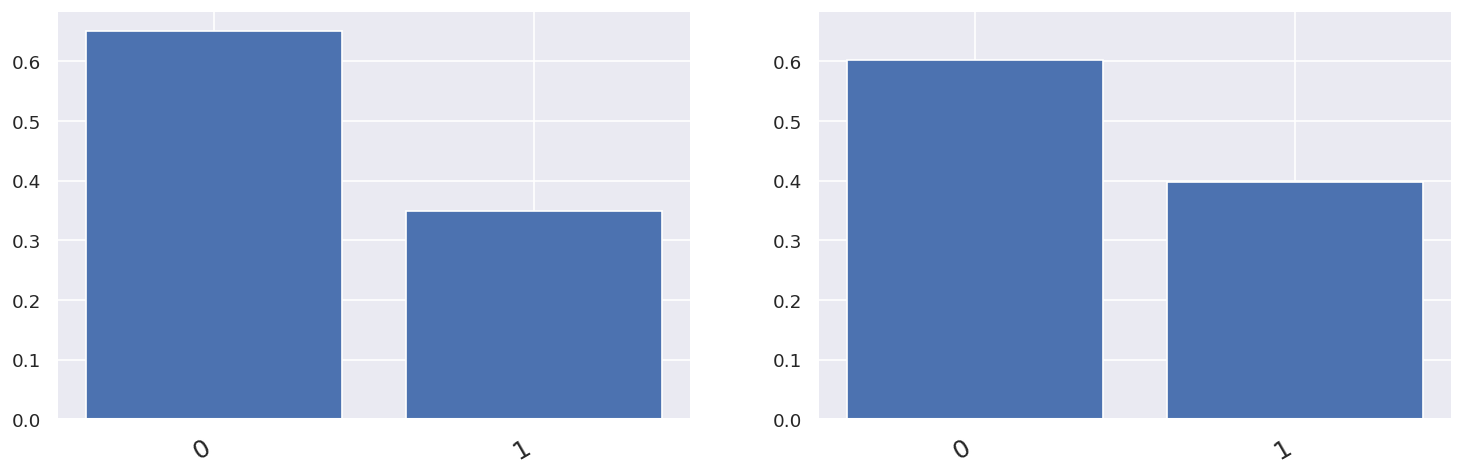

In [16]:
for attribute in synthetic_df.columns:
    print(attribute)
    inspector.compare_histograms(attribute)

### 5.3 compare pairwise mutual information

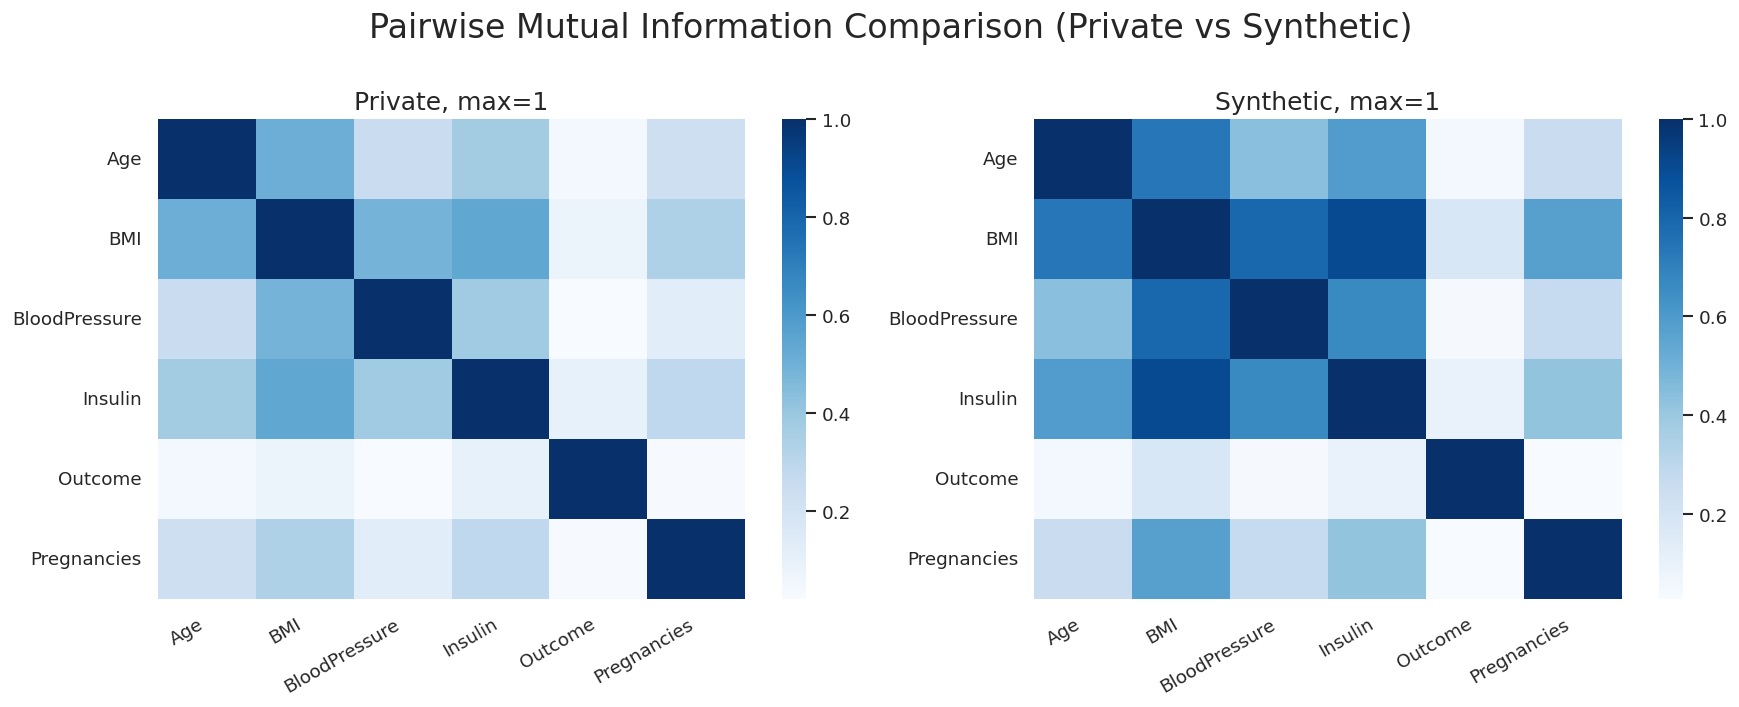

In [17]:
inspector.mutual_information_heatmap()

# 其他种类可视化的比较

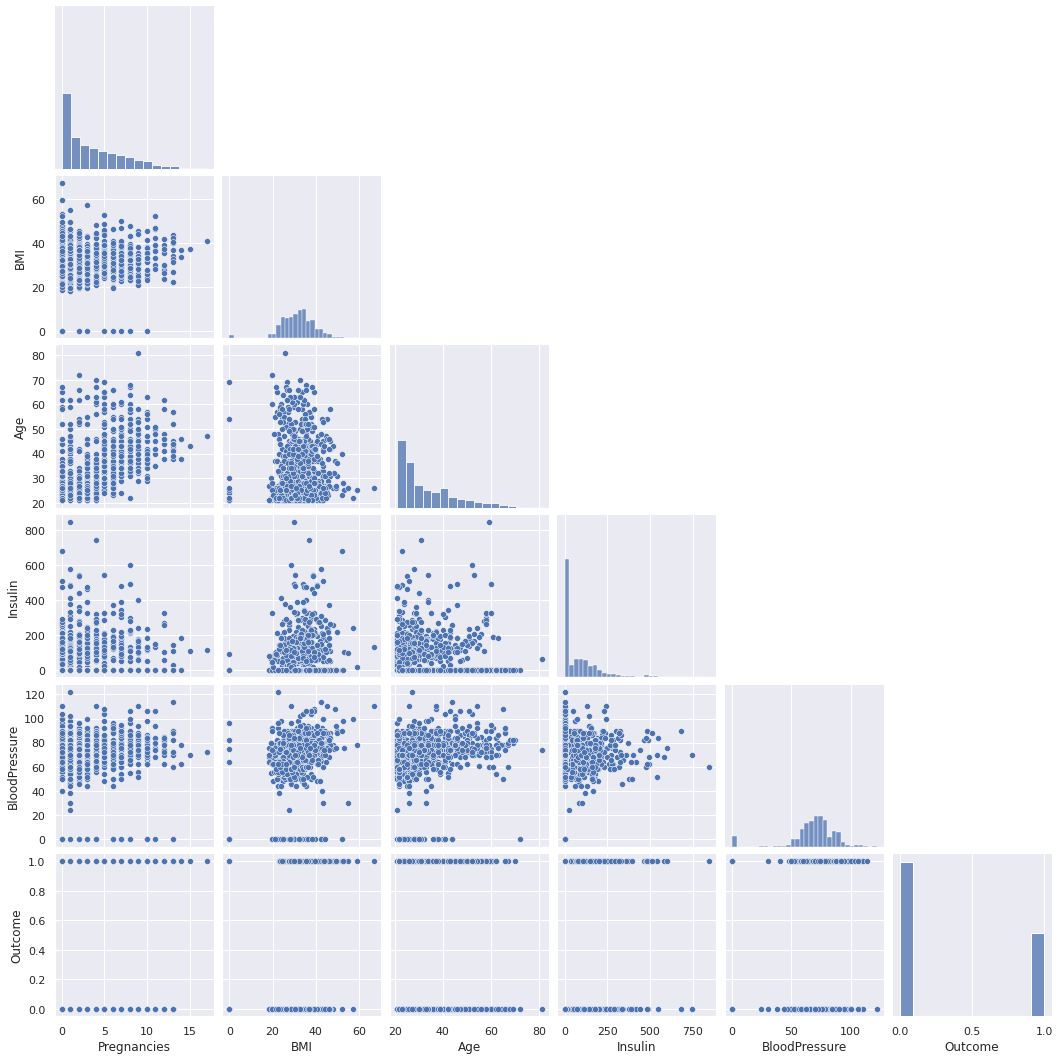

In [18]:
original_sns_plot = sns.pairplot(input_df, corner=True)

In [19]:
original_sns_plot.savefig('./fig/original_diabetes_pairplot.png')

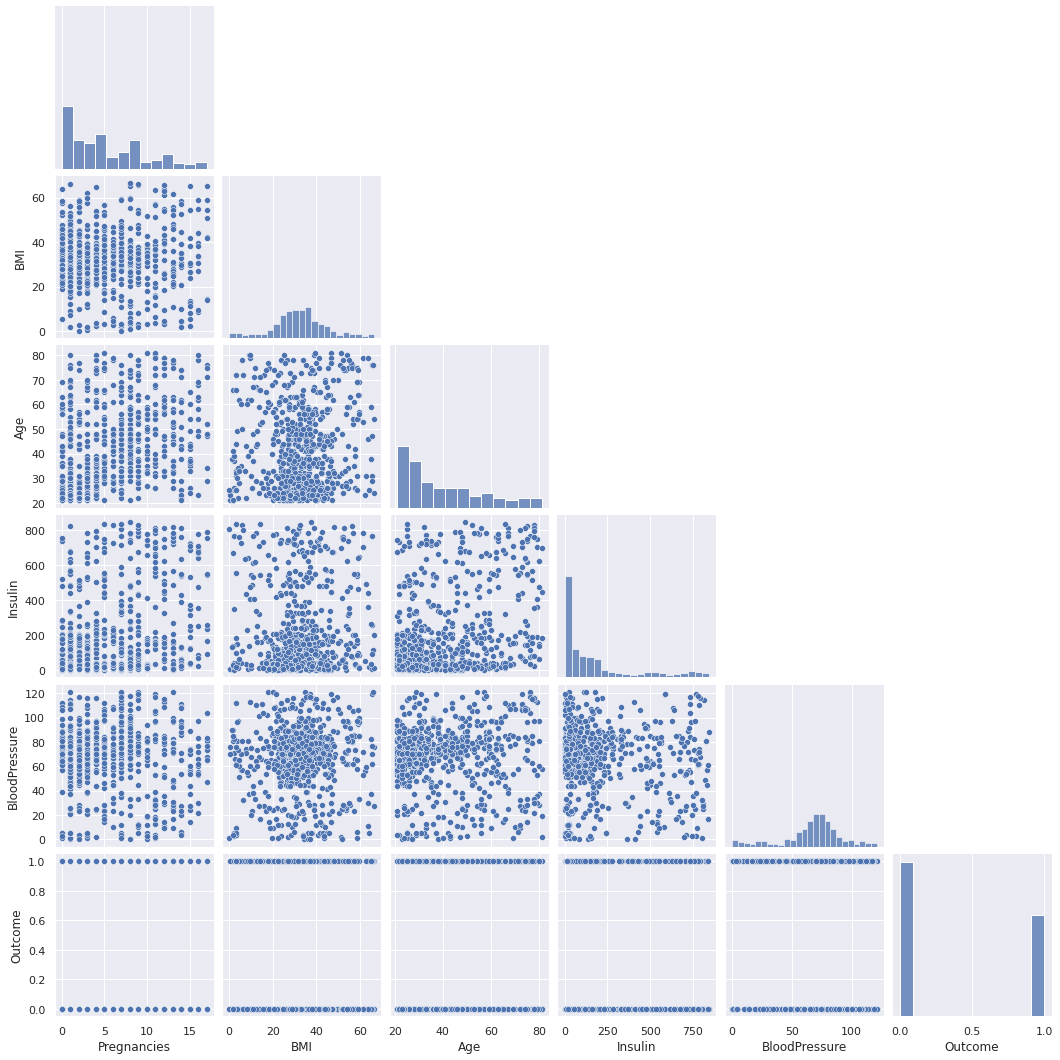

In [20]:
synthetic_sns_plot = sns.pairplot(synthetic_df, corner=True)

In [21]:
synthetic_sns_plot.savefig('./fig/synthetic_diabetes_pairplot.png')